
Goals:

* Understand the important role of "randomization" in machine learning.
* Implement Radial Basis Function using your first customized `keras.layers.Layer` or `torch.nn.Module`.
* Admire Darwin and his theory with genetic algorithm and evolution strategy.


In [4]:
# All libraries we use for this HW, run this block first!
#%tensorflow_version 2.x
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.python.ops import init_ops
from sklearn.cluster import KMeans
np.random.seed(8)
tf.random.set_seed(8)

X_digit, y_digit = load_digits(return_X_y=True)
X_digit_train, X_digit_test, y_digit_train, y_digit_test = train_test_split(X_digit, y_digit, test_size=0.3)

# Question 1: A good initialization is the one that you never know


![alt text](https://drive.google.com/uc?export=view&id=15bvT51OngFUT96ru24IymHRyt2wBZVly)

The above figure illustrates the `crossentropy` loss surface in relation to the parameters of the network $W_1$ and $W_2$.

As you can see, by just randomly picking the initial values for the weights, we could land right at the optimum position.

With this _mindset_, answer question **a)** and **b)**

### **a)** Every randomization is _"equal"_, but some are more _"equal"_ than the others.

The back-propagated gradients were smaller as one moves away from the output layer. As a result, the normalization factor may therefore be important when
initializing deep networks because of the multiplicative effect through layers [1]. 

A **normalized initialization** is proposed to maintain activation variances and back-propagated gradients variance as one moves up or down the network [1]. 

> In short, using equation **(16)** in the paper [1] to implement the normalized initialization in the following code block.

**[1]** Glorot, X., Bengio, Y., n.d. [Understanding the difﬁculty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).


In [5]:
class Uniform(init_ops.Initializer):

  def __call__(self, shape, dtype=None, partition_info=None):
    return tf.random.uniform(shape=shape, minval=0, maxval=None, dtype=dtype)


class NormalizedUniform(init_ops.Initializer):

  def __call__(self, shape, dtype=None, partition_info=None):
    # TODO: finish the implementation of NormalizedUniform initialization
    # (the return here is just copy paste from above Uniform, you could delete)
    #w = tf.random.uniform(shape=shape, minval=0, maxval=None, dtype=dtype )
    #return tf.keras.utils.normalize( w , axis=1,order=1 )
    return tf.Variable(tf.compat.v1.glorot_uniform_initializer()(shape))



Trained 5 different models with `Uniform` initialization
Trained 10 different models with `Uniform` initialization
Trained 5 different models with `NormalizedUniform` initialization
Trained 10 different models with `NormalizedUniform` initialization


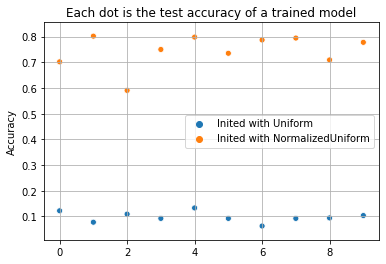

In [6]:
#@title Run the following code block to debug your initializer
def repeat_train_model(init_class):
  uniform_acc = []
  for i in range(10):
    model = keras.Sequential([
        keras.layers.Dense(64,
                           kernel_initializer=init_class(),
                           activation='relu'),
        keras.layers.Dense(64,
                           kernel_initializer=init_class(),
                           activation='relu'),
        keras.layers.Dense(10, activation='softmax'),
    ])
    model.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
    # we intentionally only train the network
    # with 10 epochs to make it underfit
    model.fit(x=X_digit_train,
              y=y_digit_train,
              batch_size=512,
              epochs=10,
              verbose=0)
    y_test_pred = np.argmax(model.predict(X_digit_test), axis=-1)
    test_acc = accuracy_score(y_digit_test, y_test_pred)
    uniform_acc.append(test_acc)
    if (i + 1) % 5 == 0:
      print("Trained %d different models with `%s` initialization" %
            ((i + 1), init_class.__name__))
  return uniform_acc


uniform_acc = repeat_train_model(Uniform)
normuniform_acc = repeat_train_model(NormalizedUniform)
n = len(uniform_acc)
sns.scatterplot(x=list(range(n)) + list(range(n)),
                y=uniform_acc + normuniform_acc,
                hue=['Inited with Uniform'] * n +
                ['Inited with NormalizedUniform'] * n)
plt.grid(True)
plt.ylabel('Accuracy')
_ = plt.title("Each dot is the test accuracy of a trained model")

### **b)** Are every problem could be solved by repeating different initialization until you get the optimum solution?

_Hint_: search for `Extreme learning machine`

Extreme Learning Machines are an important emergent machine learning techniques. The main aspects of these techniques is that <b> they do not need a learning process </b> to calculate the parameters of the models.Essentially, an EML is a Single-Layer Feed-Forward Neural Network (SLFN). ELM theory show that the value of the weight of this hidden layer need not to be tuned, and be therefore independent of the training data.
The universal approximation property implies that an EML can solve any regression problem with a desired accuracy, if it has enough hidden neurons and training data to learn parameters for all the hidden neurons.
EMLs also benefit from model structure and regularization, <b> which reduces the negatives effects of random initialization and overfitting. </b> So, by using extreme learning machines we can solve the problem of random initialization, when some problems could not be solved by repeating different initialization until we get the optimum solution.

# Question 2: Radial Basis Function (RBF)

The RBF neural networks implement the function:

$s(x) = b_0 + \sum_i^Mw_i\Phi\big( ||\vec{x} - \vec{c_i}|| \big) \tag{1}$

where:

* $b_0 \in \Re$ is the bias term 
* $w_i \in \Re$ is the weight value for neuron unit $i^{th}$
* $\vec{x} \in \Re^N$ is the input vector
* $\vec{c_i} \in \Re^N$ is the center vector of neuron unit $i^{th}$

The basis function

$\Phi(||\vec{x} - \vec{c_i}||) = exp\big(-\frac{||\vec{x} - \vec{c_i}||^2}{\beta^2}\big) \tag{2}$

and $||\vec{x} - \vec{c_i}|| = \sqrt{\sum(\vec{x} - \vec{c_i})^2}$

Design a RBF to approximate the following function:

$y = sin(x) \times cos(x), \text{ } 0 \leq x \leq 2\pi \tag{3}$



### **a)** Finish the following function to generate training and testing data for the RBF.

In [15]:
def generate_data( NUM_SAMPLES=1000 ):

  X = np.linspace(-np.pi, np.pi, NUM_SAMPLES )
  X = X.reshape((NUM_SAMPLES, 1))
  y = np.cos( X )*np.sin( X )
  y=y.ravel()
  print(X.shape,y.shape)
  
  return X,y

x, y = generate_data()
assert x.ndim == 2, "Your input must be 2-D"
assert y.ndim == 1, "Your target must be 1-D"
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

(1000, 1) (1000,)


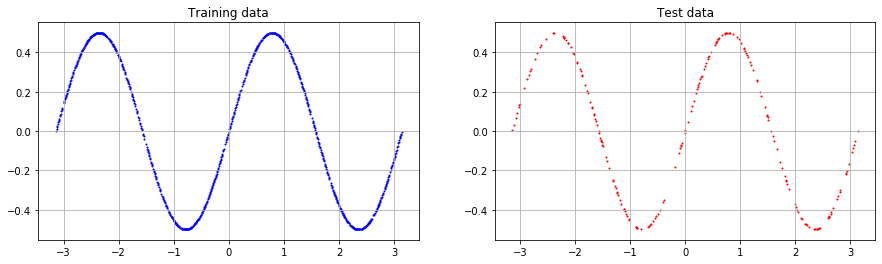

In [8]:
#@title Run this blog to debug your data generation
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(x_train, y_train, c='b', s=1)
plt.grid(True)
plt.title("Training data")
plt.subplot(1, 2, 2)
plt.scatter(x_test, y_test, c='r', s=1)
plt.grid(True)
_ = plt.title("Test data")

### **b)** Finish the implementation of the `RadialBasisFunction` class

Did your *RBF* fit the data? (i.e. it provides a sinusoid curve in the prediction)

If not, could you explain why? (_Hint_: again the initialization is important)

In [9]:
from keras import backend as K
from keras.layers import Layer
tf.keras.backend.set_floatx('float64')

class RadialBasisFunction(keras.layers.Layer):

  def __init__(self, units, center_initializer='glorot_uniform', beta=1.0):
    super().__init__()
    self.units = int(units)
    self.beta = beta
    self.loss=0
    self.center_initializer = center_initializer
    gamma=0.5
    self.gamma = K.cast_to_floatx(gamma)

  def build(self, input_shape):
    super().build(input_shape)
    input_dim = input_shape[-1]
    # you have to initialize 3 parameters
    # the weight for each neuron unit
    # the center which is a vector for each neuron
    # the bias for all the neurons
    # TODO: initialize your parameters here
    self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
    
    #self.weights = np.random.randint(8)
    self.bias = np.random.randn(1)
    #self.center = [np.random.uniform(-1, 1, input_dim) for i in range(0,8)]
    
    K_cent= 8
    km= KMeans(n_clusters= K_cent, max_iter= 100)
    km.fit(x_train)
    self.center= km.cluster_centers_
    
    norm=np.linalg.norm(self.center, ord=1)
    if norm==0:
        norm=np.finfo(self.center.dtype).eps
    self.center = self.center/norm



  def call(self, inputs):
    # need to expand dims to make inputs broadcastable to the center
    # We have something like these:
    # * inputs [batch_size, input_dim] -> [batch_size, 1, input_dim]
    # * center [units, input_dims]
    # * inputs-center [batch_size, units, input_dims]
    # * radius [batch_size, units]
    # TODO: using Eq (1) and (2) finish the calculation of RBF
    
     
    radius = K.expand_dims(inputs) - self.mu
    l2 = K.sum(K.pow(radius, 2), axis=-1)
    outputs = K.exp(-1 * self.gamma * l2)
        
    outputs = tf.reduce_sum(outputs + self.bias, axis=-1)
    return outputs

Using TensorFlow backend.


In [10]:
# run this block to create your rbf, you might modify it as necessary
rbf = RadialBasisFunction(units=8, beta=1.0)

Epoch#9  Loss:0.6722
Epoch#19  Loss:0.6467
Epoch#29  Loss:0.6249
Epoch#39  Loss:0.6078
Epoch#49  Loss:0.5956
Epoch#59  Loss:0.5870
Epoch#69  Loss:0.5794
Epoch#79  Loss:0.5657
Epoch#89  Loss:0.5359
Epoch#99  Loss:0.4973
Test Loss: 0.486560520163016


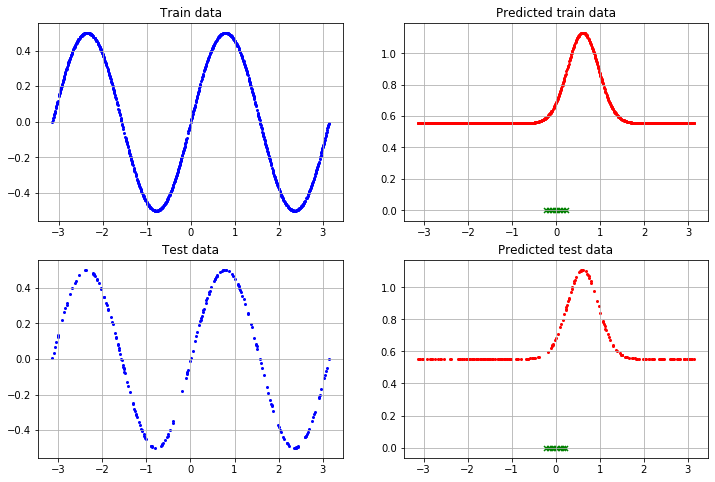

In [11]:
#@title Run the following code block to use backpropagation training your rbf and debug it (NOTE: the green cross is the center of each neuron unit)
opt = tf.optimizers.Adam(learning_rate=0.01)
fn_loss = tf.losses.mean_squared_error
for epoch in range(100):
  with tf.GradientTape() as tape:
    y_train_pred = rbf(x_train)
    loss = fn_loss(y_train, y_train_pred)
  grads = tape.gradient(loss, rbf.trainable_weights)
  opt.apply_gradients(
      grads_and_vars=[(g, w) for g, w in zip(grads, rbf.trainable_weights)])
  if (epoch + 1) % 10 == 0:
    print("Epoch#%d  Loss:%.4f" % (epoch, loss))

y_test_pred = rbf(x_test)
print("Test Loss:", fn_loss(y_test, y_test_pred).numpy())

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
_ = plt.title("Predicted test data")

# Question 3: Use genetic algorithm to train the network of Radial Basis Function.

![alt text](https://drive.google.com/uc?export=view&id=1XSFo1Ep5w0lll5_r3XewSxvDHhLPmxwT)

The above flow chart describes the genetic algorithm and the purpose of each function you have to implement in **a)**, **b)** and **c)** (only the `TODO` places)

### **a)** Finish the implementation of all essential functions for GA

In [11]:
def initialze_population(units, input_shape, size=100):
    population=[]
    
    for i in range(0,size):
        rbf=RadialBasisFunction(units=units, beta=1.0)
        rbf.build(input_shape)
        population.append(rbf)
    print( len(population ))
    
    return population

def mutate(rbf, mean=0., stddev=1., mutation_rate=0.1):
  # concatenate all parameters into single vector, easier to handle
  params = tf.concat(
      [tf.reshape(rbf.weights, [-1]),
       tf.reshape(rbf.center, [-1]), rbf.bias],
      axis=0)
  #I get the rbf newtworks one by one and created a self.loss in the rbf class
  #So I am mutating all population one by one by multiplying with the mutation rate.
  # Mutation changes a single gene in each offspring randomly.
  rbf.loss*=0.1;  
  return rbf


def crossover(rbf1, rbf2):
  rbf = RadialBasisFunction(units=rbf1.units)
  rbf.build(input_shape=(None, rbf1.center.shape[1]))
  # concatenate all parameters into single vector, easier to handle
  params1 = tf.concat(
      [tf.reshape(rbf1.weights, [-1]),
       tf.reshape(rbf1.center, [-1]), rbf1.bias],
      axis=0)
  params2 = tf.concat(
      [tf.reshape(rbf2.weight, [-1]),
       tf.reshape(rbf2.center, [-1]), rbf2.bias],
      axis=0)
  # new params inherit from both mum and dad
  new_params = (params1 + params2) / 2
  rbf.weight.assign(tf.reshape(new_params[:rbf.units], rbf.weight.shape))
  rbf.center.assign(tf.reshape(new_params[rbf.units:-1], rbf.center.shape))
  rbf.bias.assign(tf.reshape(new_params[-1], rbf.bias.shape))
  return rbf
losses=[]
def select(x_train,
           y_train,
           population,
           n_best=20,
           loss_func=tf.losses.mean_squared_error):
    
    # TODO
   
    for i in range(0,len(population)):
     opt = tf.optimizers.Adam(learning_rate=0.01)
     fn_loss = tf.losses.mean_squared_error
     for epoch in range(100):
        with tf.GradientTape() as tape:
             y_train_pred = population[i](x_train)
             loss = fn_loss(y_train, y_train_pred)
        grads = tape.gradient(loss, population[i].trainable_weights)
        opt.apply_gradients( grads_and_vars=[(g, w) for g, w in zip(grads, population[i].trainable_weights)])
        if (epoch + 1) % 100 == 0:
           print("RBF#%d  Loss:%.4f" % (i, loss))
           losses.append(loss)
           population[i].loss=loss
           #np.sort(losses)
    return population[:20],losses[:20]
    # note: this function has to return both a list of best candidates and best losses
   

### **b)** Writing the training procedure for Genetic algorithm

In [12]:
def genetic_algorithm(crossover_func=crossover,
                      n_generation=1,
                      population_size=80,
                      n_best=20):
  population = initialze_population(8,
                                    input_shape=(None, 1),
                                    size=population_size)
  history = []
  best_rbf = None
  for generation in range(n_generation):
    best_candidates, best_losses = select(x_train,
                                          y_train,
                                          population,
                                          n_best=n_best)
    best_losses = np.asarray(best_losses)
    # The parents will be selected based how good they are,
    # determine the probabilities of each candidate here.
    # TODO: assign appropriate probabilities for each candidate
    #candidates_probabilities = 1+1/(np.sum( best_candidates ))

    # crossover create a new off-spring with mutation
    new_population = []
    for i in range(population_size):
       offspring = mutate( population[i] )
       new_population.append(offspring)
    population = new_population

    # since losses is sorted in ascending order, the first one is the smallest
    # (i.e. the best) loss value
    if (generation + 1) % 5 == 0:
       print("Generation#%d  Loss:%.4f" % (generation + 1, best_losses[0]))
    history.append(best_losses[0])
    
    if best_losses[0] <= np.min(history):
       best_rbf = best_candidates[0]

  return best_rbf

80
RBF#0  Loss:0.6392
RBF#1  Loss:0.2611
RBF#2  Loss:0.2190
RBF#3  Loss:2.7893
RBF#4  Loss:0.1266
RBF#5  Loss:0.3850
RBF#6  Loss:0.1102
RBF#7  Loss:2.7088
RBF#8  Loss:3.7534
RBF#9  Loss:0.1343
RBF#10  Loss:0.1509
RBF#11  Loss:0.1534
RBF#12  Loss:0.1007
RBF#13  Loss:2.8271
RBF#14  Loss:3.7128
RBF#15  Loss:3.4055
RBF#16  Loss:0.1552
RBF#17  Loss:0.3083
RBF#18  Loss:0.9561
RBF#19  Loss:0.3142
RBF#20  Loss:0.5067
RBF#21  Loss:4.0629
RBF#22  Loss:0.1210
RBF#23  Loss:1.3608
RBF#24  Loss:1.8421
RBF#25  Loss:1.6233
RBF#26  Loss:0.5691
RBF#27  Loss:0.9146
RBF#28  Loss:2.8938
RBF#29  Loss:0.1513
RBF#30  Loss:1.7954
RBF#31  Loss:0.2082
RBF#32  Loss:1.0261
RBF#33  Loss:0.9001
RBF#34  Loss:0.1359
RBF#35  Loss:0.3890
RBF#36  Loss:0.7252
RBF#37  Loss:0.1767
RBF#38  Loss:1.0277
RBF#39  Loss:0.1002
RBF#40  Loss:3.0529
RBF#41  Loss:0.4883
RBF#42  Loss:0.7094
RBF#43  Loss:0.6018
RBF#44  Loss:0.1351
RBF#45  Loss:0.2011
RBF#46  Loss:2.3881
RBF#47  Loss:1.5887
RBF#48  Loss:2.0791
RBF#49  Loss:0.1152
RBF#50 

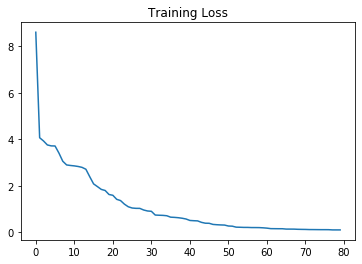

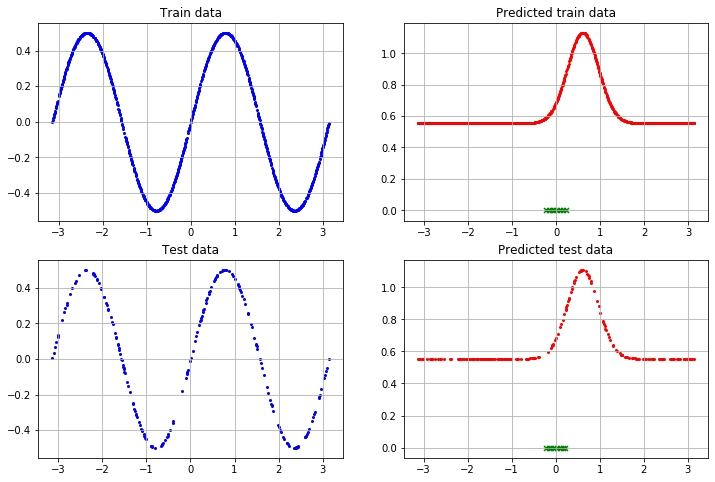

In [14]:
#@title Run this code block to debug your genetic algorithm
rbf = genetic_algorithm()
assert isinstance(rbf, RadialBasisFunction), "genetic_algorithm must return an instance of RadialBasisFunction class"
plt.figure()
losses = np.sort(losses )[::-1]
plt.plot(losses)
plt.title("Training Loss")
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
_ = plt.title("Predicted test data")

### **c)** Something wrong with `crossover` function, could you fix it? Finish the implementation of `crossover_new`

**NOTE**: if the first `crossover` function is right, then Darwin must be wrong. 

In [13]:
def crossover_new(rbf1, rbf2):
  rbf = RadialBasisFunction(units=rbf1.units)
  rbf.build(input_shape=(None, rbf1.center.shape[1]))
  # concatenate all parameters into single vector, easier to handle
  params1 = tf.concat(
      [tf.reshape(rbf1.weights, [-1]),
       tf.reshape(rbf1.center, [-1]), rbf1.bias],
      axis=0)
  params2 = tf.concat(
      [tf.reshape(rbf2.weight, [-1]),
       tf.reshape(rbf2.center, [-1]), rbf2.bias],
      axis=0)
  # new params inherit from both mum and dad
  new_params = (params1 + params2) / 2
  rbf.weight.assign(tf.reshape(new_params[:rbf.units], rbf.weight.shape))
  rbf.center.assign(tf.reshape(new_params[rbf.units:-1], rbf.center.shape))
  rbf.bias.assign(tf.reshape(new_params[-1], rbf.bias.shape))
  return rbf
    
  
  # TODO: finish the crossover_new and return new rbf offspring

(1000, 1) (1000,)
80
RBF#0  Loss:0.4318
RBF#1  Loss:0.7976
RBF#2  Loss:0.1574
RBF#3  Loss:0.3232
RBF#4  Loss:1.1215
RBF#5  Loss:0.1101
RBF#6  Loss:0.3317
RBF#7  Loss:5.7738
RBF#8  Loss:0.4119
RBF#9  Loss:1.4689
RBF#10  Loss:5.9093
RBF#11  Loss:0.0969
RBF#12  Loss:0.3348
RBF#13  Loss:0.0996
RBF#14  Loss:0.4277
RBF#15  Loss:0.8172
RBF#16  Loss:0.1244
RBF#17  Loss:0.1216
RBF#18  Loss:1.3867
RBF#19  Loss:0.3965
RBF#20  Loss:0.4926
RBF#21  Loss:0.0971
RBF#22  Loss:0.0940
RBF#23  Loss:0.2486
RBF#24  Loss:0.1449
RBF#25  Loss:0.1263
RBF#26  Loss:3.8804
RBF#27  Loss:0.2281
RBF#28  Loss:0.3292
RBF#29  Loss:0.1008
RBF#30  Loss:0.9249
RBF#31  Loss:0.9177
RBF#32  Loss:0.4127
RBF#33  Loss:2.0482
RBF#34  Loss:1.1239
RBF#35  Loss:0.3123
RBF#36  Loss:0.8315
RBF#37  Loss:2.3176
RBF#38  Loss:0.1324
RBF#39  Loss:1.3675
RBF#40  Loss:1.3430
RBF#41  Loss:1.4735
RBF#42  Loss:0.3600
RBF#43  Loss:0.1043
RBF#44  Loss:0.6740
RBF#45  Loss:1.7472
RBF#46  Loss:1.0731
RBF#47  Loss:0.0941
RBF#48  Loss:2.7553
RBF#49  L

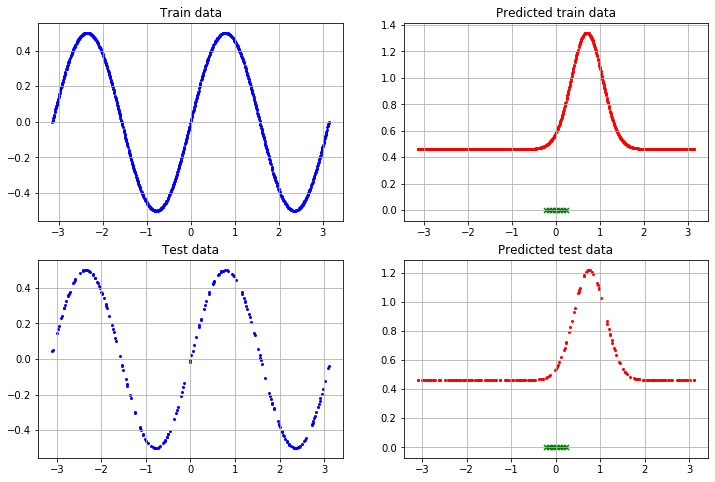

In [22]:
#@title Run this code block to debug your `crossover_new` function
x, y = generate_data()
#assert x.ndim == 2, "Your input must be 2-D"
#assert y.ndim == 1, "Your target must be 1-D"
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rbf = genetic_algorithm(crossover_func=crossover_new)
opt = tf.optimizers.Adam(learning_rate=0.1)
fn_loss = tf.losses.mean_squared_error
for epoch in range(1):
  with tf.GradientTape() as tape:
    y_train_pred = rbf(x_train)
    loss = fn_loss(y_train, y_train_pred)
  grads = tape.gradient(loss, rbf.trainable_weights)
  opt.apply_gradients(
      grads_and_vars=[(g, w) for g, w in zip(grads, rbf.trainable_weights)])
y_test_pred = rbf(x_test)

assert isinstance(rbf, RadialBasisFunction), "genetic_algorithm must return an instance of RadialBasisFunction class"
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(x_train, y_train, c='b', s=4)
plt.grid(True)
plt.title("Train data")
plt.subplot(2, 2, 2)
plt.scatter(x_train, y_train_pred, c='r', s=4)
plt.scatter(rbf.center.ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
plt.grid(True)
plt.title("Predicted train data")

plt.subplot(2, 2, 3)
plt.scatter(x_test, y_test, c='b', s=4)
plt.grid(True)
plt.title("Test data")
plt.subplot(2, 2, 4)
plt.scatter(x_test, y_test_pred, c='r', s=4)
plt.grid(True)
plt.scatter(rbf.center.ravel(), [0] * rbf.units,
            c='g',
            marker='x',
            s=25)
_ = plt.title("Predicted test data")